<h1 align="center">Human Activity Recognition</h1>

Smartphones we use daily have two types of sensors embedded in them. An accelerometer and a Gyroscope.


Experiments were carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities 

    1. WALKING
    2. WALKING_UPSTAIRS
    3. WALKING_DOWNSTAIRS
    4. SITTING
    5. STANDING
    6. LAYING
    
wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, the researchers captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments were video-recorded to label the data manually. The obtained dataset was randomly partitioned into two sets, where 70% of the volunteers were selected for generating the training data and 30% the test data.

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). 

The data is provided by [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones), and for each record in the dataset following information is provided:

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration.
- Triaxial Angular velocity from the gyroscope.
- A 561-feature vector with time and frequency domain variables.
- Its activity label.
- An identifier of the subject who carried out the experiment.

# Objective

Given the data from Accelerometer and Gyroscppe, identify what activities were being performed. In other words, this is a 6 class classification problem.

The 561 features are expert engineered features that are made available for training ML algorithms directly. We will train ML models using these hand-crafted features, as well as using raw signal data using Recurrent Neural Networks (LSTM). Let's start.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import pickle
import joblib
import re
from sklearn.manifold import TSNE
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, classification_report
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from prettytable import PrettyTable
from keras.regularizers import l1, l2

%reload_ext jupyternotify

Using TensorFlow backend.


<IPython.core.display.Javascript object>

In [2]:
np.random.seed(seed=13)

# A look at the data

The file `features.txt` is a list of all the 561 expert engineered features.

The files `X_train/X_test` are the training and test sets respectively of 561 expert engineered features.

The files `y_train/y_test` are the training and test target labels of 561 expert engineered features.

The files `subject_train/subject_test` are the index of the person whose data the records indicate.

In [9]:
with open('HAR/UCI_HAR_Dataset/features.txt') as f:
    print(f.read()[:97])

1 tBodyAcc-mean()-X
2 tBodyAcc-mean()-Y
3 tBodyAcc-mean()-Z
4 tBodyAcc-std()-X
5 tBodyAcc-std()-Y


Let's store the feature names in a python list. This will be helpful in giving column names to our dataframe.

In [10]:
with open('HAR/UCI_HAR_Dataset/features.txt') as f:
    feature_names = [line.split()[1] for line in f.readlines()]

In [11]:
feature_names[:5]

['tBodyAcc-mean()-X',
 'tBodyAcc-mean()-Y',
 'tBodyAcc-mean()-Z',
 'tBodyAcc-std()-X',
 'tBodyAcc-std()-Y']

There are 561 human engineered features in the data

In [7]:
len(feature_names)

561

**Clean the feautre names**

Each feature has certain brackets or paranthesis. Let's remove them in the interest of reducing clutter. The cleaned names look much better.

In [92]:
feature_names = [re.sub('[^a-zA-Z]','',x) for x in feature_names]
feature_names[:5]

['tBodyAccmeanX',
 'tBodyAccmeanY',
 'tBodyAccmeanZ',
 'tBodyAccstdX',
 'tBodyAccstdY']

**Load the train data**

Now, we will load the data into a dataframe. We will also add two new columns `subject` and `activity_name`.

In [12]:
df_train = pd.read_csv('HAR/UCI_HAR_Dataset/train/X_train.txt',
                      header=None,
                      sep='\s+')

df_train.columns = feature_names

# add subject column to the dataframe
df_train['subject'] = pd.read_csv('HAR/UCI_HAR_Dataset/train/subject_train.txt',
                                 header=None,
                                 squeeze=True)
# Load y
df_train['activity_name'] = pd.read_csv('HAR/UCI_HAR_Dataset/train/y_train.txt',
                                       names=['Activity'],
                                       squeeze=True).map({
                                           1: 'WALKING',
                                           2: 'WALKING_UPSTAIRS',
                                           3: 'WALKING_DOWNSTAIRS',
                                           4: 'SITTING',
                                           5: 'STANDING',
                                           6: 'LAYING'
                                       })

This is what the train dataframe looks like

In [99]:
df_train.sample(5)

,tBodyAccmeanX,tBodyAccmeanY,tBodyAccmeanZ,tBodyAccstdX,tBodyAccstdY,tBodyAccstdZ,tBodyAccmadX,tBodyAccmadY,tBodyAccmadZ,tBodyAccmaxX,...,fBodyBodyGyroJerkMagkurtosis,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject,activity_name
6226,0.223509,0.007550,-0.227925,-0.355371,-0.023827,-0.227798,-0.388454,-0.008506,-0.205892,-0.178802,...,-0.100565,-0.017625,0.606660,0.976422,-0.731393,-0.526855,0.275045,0.297834,27,WALKING_UPSTAIRS
1420,0.249995,-0.028395,-0.065954,-0.258358,-0.194830,0.316543,-0.271003,-0.245761,0.278085,-0.248338,...,-0.525824,0.392290,-0.168771,-0.448194,-0.096741,-0.648913,0.176077,0.256857,7,WALKING
1642,0.276670,-0.018358,-0.106067,-0.997450,-0.989827,-0.990374,-0.997517,-0.990827,-0.990106,-0.944642,...,-0.904918,0.091607,-0.215537,0.201415,-0.153388,-0.848900,0.196150,0.055557,8,STANDING
2501,0.285235,0.013752,0.062715,0.052507,0.311467,0.270616,-0.055039,0.098364,0.186643,0.650352,...,-0.635389,0.303488,0.354808,-0.912906,0.238589,-0.483857,0.279446,0.330014,14,WALKING_DOWNSTAIRS
4507,0.128784,-0.107771,-0.230366,0.097093,0.180205,-0.005200,0.031868,0.200236,-0.034930,0.307777,...,-0.463573,0.164621,0.326308,-0.926669,-0.717842,-0.720147,0.291267,0.008059,22,WALKING_UPSTAIRS


**Load the test data**

Similarly, we load the test datasets

In [13]:
df_test = pd.read_csv('HAR/UCI_HAR_Dataset/test/X_test.txt',
                      header=None,
                      sep='\s+')

df_test.columns = feature_names

# add subject column to the dataframe
df_test['subject'] = pd.read_csv('HAR/UCI_HAR_Dataset/test/subject_test.txt',
                                 header=None,
                                 squeeze=True)
# Load y
df_test['activity_name'] = pd.read_csv('HAR/UCI_HAR_Dataset/test/y_test.txt',
                                       names=['Activity'],
                                       squeeze=True).map({
                                           1: 'WALKING',
                                           2: 'WALKING_UPSTAIRS',
                                           3: 'WALKING_DOWNSTAIRS',
                                           4: 'SITTING',
                                           5: 'STANDING',
                                           6: 'LAYING'
                                       })

A sample of the test dataset

In [101]:
df_test.sample(5)

,tBodyAccmeanX,tBodyAccmeanY,tBodyAccmeanZ,tBodyAccstdX,tBodyAccstdY,tBodyAccstdZ,tBodyAccmadX,tBodyAccmadY,tBodyAccmadZ,tBodyAccmaxX,...,fBodyBodyGyroJerkMagkurtosis,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject,activity_name
777,0.277174,-0.034147,-0.103465,-0.986801,-0.972027,-0.968283,-0.990887,-0.977417,-0.975801,-0.920211,...,-0.239486,0.057556,0.143542,-0.369842,0.114278,-0.883470,0.059023,0.094235,9,STANDING
1230,0.295573,-0.011682,-0.125010,-0.993026,-0.989310,-0.951979,-0.994155,-0.989030,-0.949167,-0.927900,...,-0.787350,-0.206955,0.152585,0.170258,-0.130286,-0.505722,-0.138834,-0.231813,12,SITTING
1801,0.206953,-0.019089,-0.136857,-0.415850,0.129005,-0.392304,-0.509721,0.085192,-0.377141,-0.049755,...,0.006705,0.607454,-0.308190,0.915222,-0.472276,-0.719024,0.291016,-0.004688,13,WALKING
1115,0.380370,-0.014864,-0.104110,-0.839526,-0.877535,-0.955267,-0.856375,-0.899684,-0.961244,-0.623497,...,-0.370980,-0.000886,-0.360377,-0.554576,0.730308,0.544764,0.996343,-0.188419,10,LAYING
2465,0.265656,-0.015345,-0.108900,-0.994687,-0.993189,-0.983637,-0.995542,-0.993232,-0.984737,-0.938670,...,-0.727001,-0.064328,0.195868,0.693428,-0.919796,0.412824,-0.636688,-0.338492,20,LAYING


The train data has 7352 data points while the test data has 2947 data points

In [14]:
df_train.shape, df_test.shape

((7352, 563), (2947, 563))

# Exploratory data analysis

**1. Are there any duplicate values?**

The following block of code indicates that there are no duplicate values in the data.

In [38]:
print('Train|Number of duplicate columns:',df_train.duplicated().sum())
print('Train|Shape of the dataframe after dropping duplicate values:', df_train.drop_duplicates().shape)
print('Test|Number of duplicate columns:',df_test.duplicated().sum())
print('Test|Shape of the dataframe after dropping duplicate values:', df_test.drop_duplicates().shape)

Train|Number of duplicate columns: 0
Train|Shape of the dataframe after dropping duplicate values: (7352, 563)
Test|Number of duplicate columns: 0
Test|Shape of the dataframe after dropping duplicate values: (2947, 563)


**2. Null Values**

There don't seem to be any Null values either. The original data is pretty clean.

In [44]:
df_train.isnull().values.any(), df_test.isnull().values.any()

(False, False)

In [103]:
df_train[df_train.isna().any(axis=1)]

,tBodyAccmeanX,tBodyAccmeanY,tBodyAccmeanZ,tBodyAccstdX,tBodyAccstdY,tBodyAccstdZ,tBodyAccmadX,tBodyAccmadY,tBodyAccmadZ,tBodyAccmaxX,...,fBodyBodyGyroJerkMagkurtosis,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject,activity_name


In [104]:
df_train[df_train.isna().any(axis=1)]

,tBodyAccmeanX,tBodyAccmeanY,tBodyAccmeanZ,tBodyAccstdX,tBodyAccstdY,tBodyAccstdZ,tBodyAccmadX,tBodyAccmadY,tBodyAccmadZ,tBodyAccmaxX,...,fBodyBodyGyroJerkMagkurtosis,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject,activity_name


**3. Distribution of subjects and the Target variable in the data**

For each person, data of all 6 activities was captured. The graphs below display how the data points for these activities are distributed. There isn't a lot of imbalance between the subjects. Each of them has contributed the same quantity of data more or less.

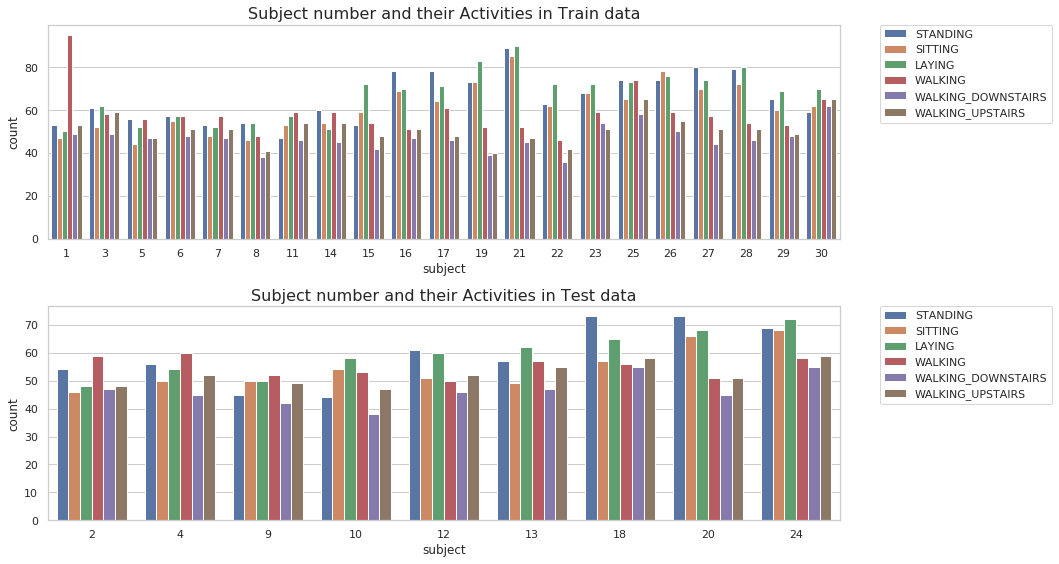

In [105]:
#sbn.set()
sbn.set_style('whitegrid')
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
sbn.countplot(x='subject', hue='activity_name', data=df_train)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Subject number and their Activities in Train data', fontsize=16)
plt.subplot(2,1,2)
sbn.countplot(x='subject', hue='activity_name', data=df_test)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Subject number and their Activities in Test data', fontsize=16)
plt.tight_layout()
plt.show()

**Datapoints per activity**

In both Train and Test datasets, the activity LAYING has the most number of data points while WALKING_DOWNSTAIRS has the lest number of datapoints. But the relative proportion of activities in the train/test sets remains very similar. So we could say they come from the same distribution.

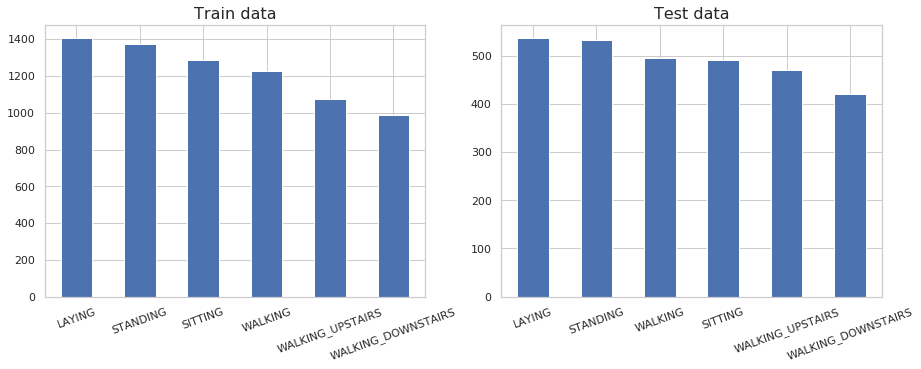

In [71]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
df_train.activity_name.value_counts().plot.bar(rot=20)
plt.title('Train data', fontsize=16)
plt.subplot(1,2,2)
df_test.activity_name.value_counts().plot.bar(rot=20)
plt.title('Test data', fontsize=16)
plt.show()

Save the data to disk to avoid doing everything again when I restart the kernel.

In [15]:
# df_train.to_csv('df_train.csv', index=False)
# df_test.to_csv('df_test.csv', index=False)

In [3]:
df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')

# Exploring features

Intuitively, we can say that if the expert engineered features are able to show noticeable difference in values for different classes of activities, our ML models will be able to train well.

Let's see how some of the features are distributed for all 6 types of activities. Of course, there are 561 unique features in the data and it's just not feasible to plot all of them here. So, I'll pick 10 random features and see how they're distributed.

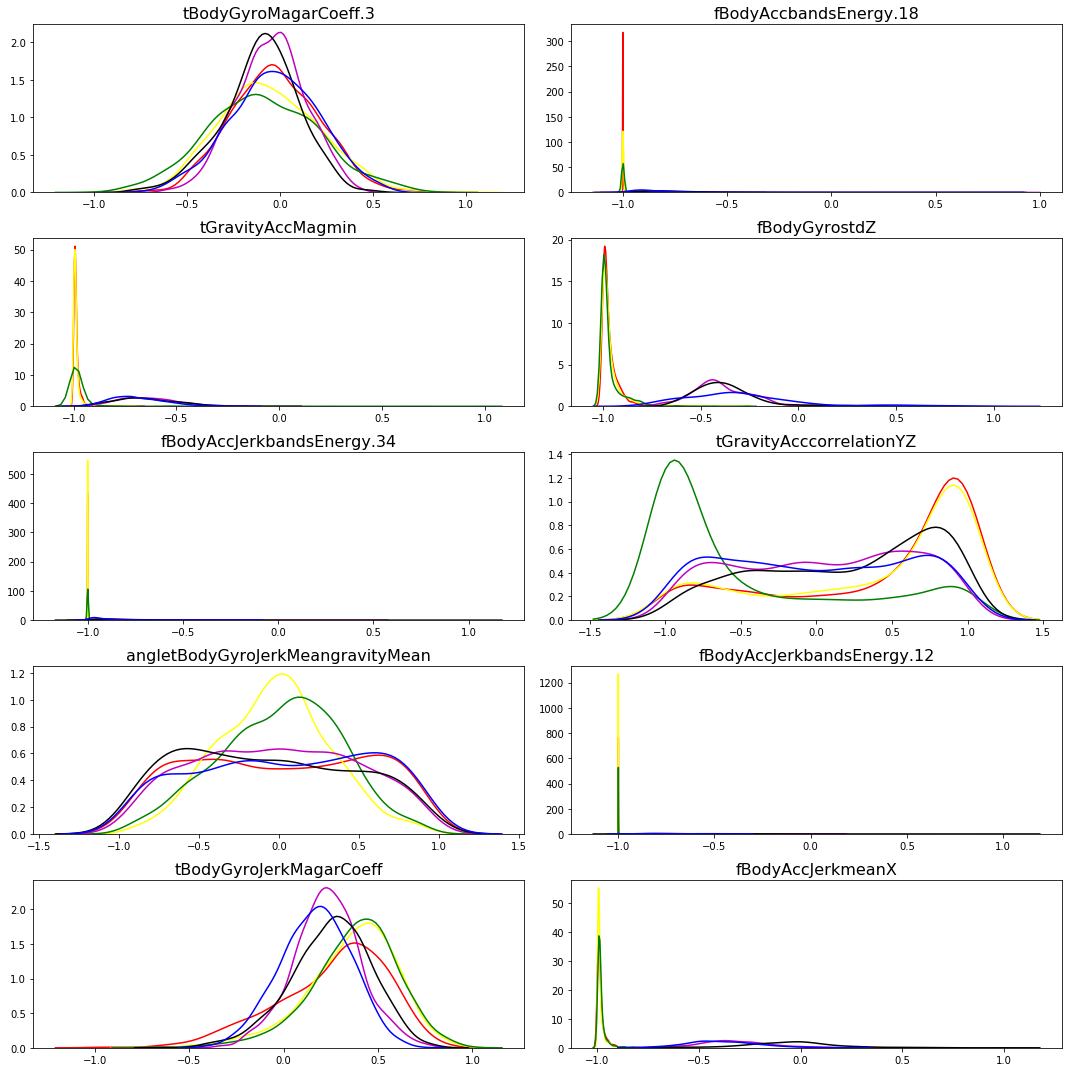

In [53]:
plt.figure(figsize=(15,15))
p = 1

for feature in np.random.choice(df_train.columns, 10, replace=False):
    plt.subplot(5,2, p)
    for ix, act in enumerate(df_train.activity_name.unique()):
        
        sbn.distplot(df_train[df_train.activity_name == act][feature],
                     kde=1,
                     norm_hist=0,
                     hist=False,
                     color=['red', 'yellow', 'green', 'm', 'black', 'blue'][ix])
        plt.title(feature, fontsize=16)
        plt.xlabel('')
    p += 1
    
plt.tight_layout()

In [54]:
df_train['activity_name'].unique()

array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

**Considering only the activity type**

Let's add another column to the data - Activity Type, which indicates whether an activity is a STATIONARY activity or a MOVING activity.

    STANDING, SITTING, LAYING -- Stationary
    WALKING, WALKING_DOWNSTAIRS, WALKING_UPSTAIRS -- Moving

In [20]:
df_train = pd.concat([
    df_train, df_train['activity_name'].map({
        'STANDING': 'STATIONARY',
        'SITTING': 'STATIONARY',
        'LAYING': 'STATIONARY',
        'WALKING': 'MOVING',
        'WALKING_DOWNSTAIRS': 'MOVING',
        'WALKING_UPSTAIRS': 'MOVING'
    }).rename('activity_type')
],
                     axis=1)

**Observe how the features differ for STATIONARY vs MOVING activities**. Some of the features have a clear difference in the distribution of the two types of activities.

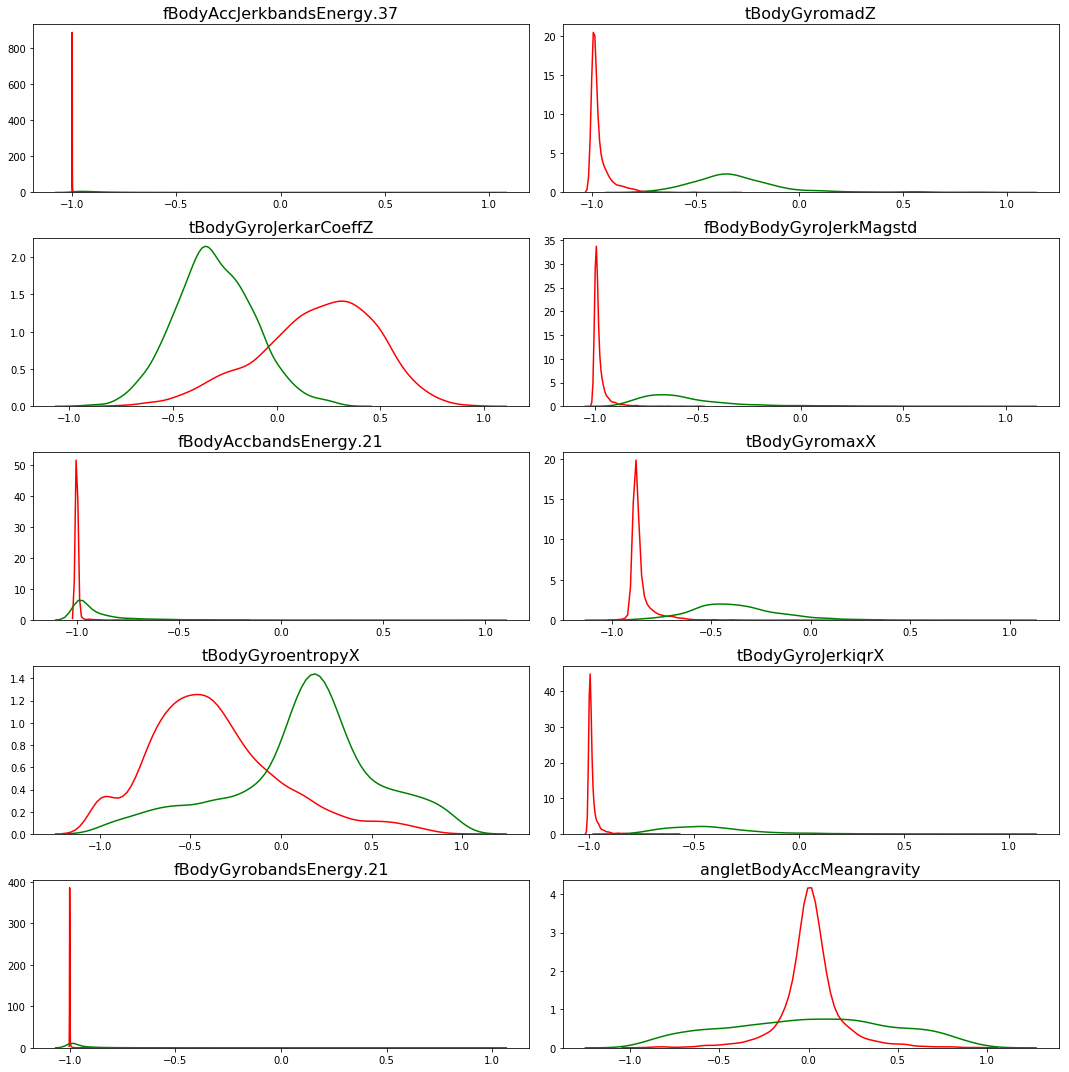

In [70]:
plt.figure(figsize=(15,15))
p = 1

for feature in np.random.choice(df_train.columns, 10, replace=False):
    plt.subplot(5,2, p)
    for ix, act in enumerate(df_train.activity_type.unique()):
        
        sbn.distplot(df_train[df_train.activity_type == act][feature],
                     kde=1,
                     norm_hist=0,
                     hist=False,
                     color=['red', 'green'][ix])
        plt.title(feature, fontsize=16)
        plt.xlabel('')
    p += 1
    
plt.tight_layout()

# Boxplots of features

For this problem, Boxplots give a better sense of the distinction between the features. We could draw a clear boundary between STATIONARY and MOVING values for some of the features below. 

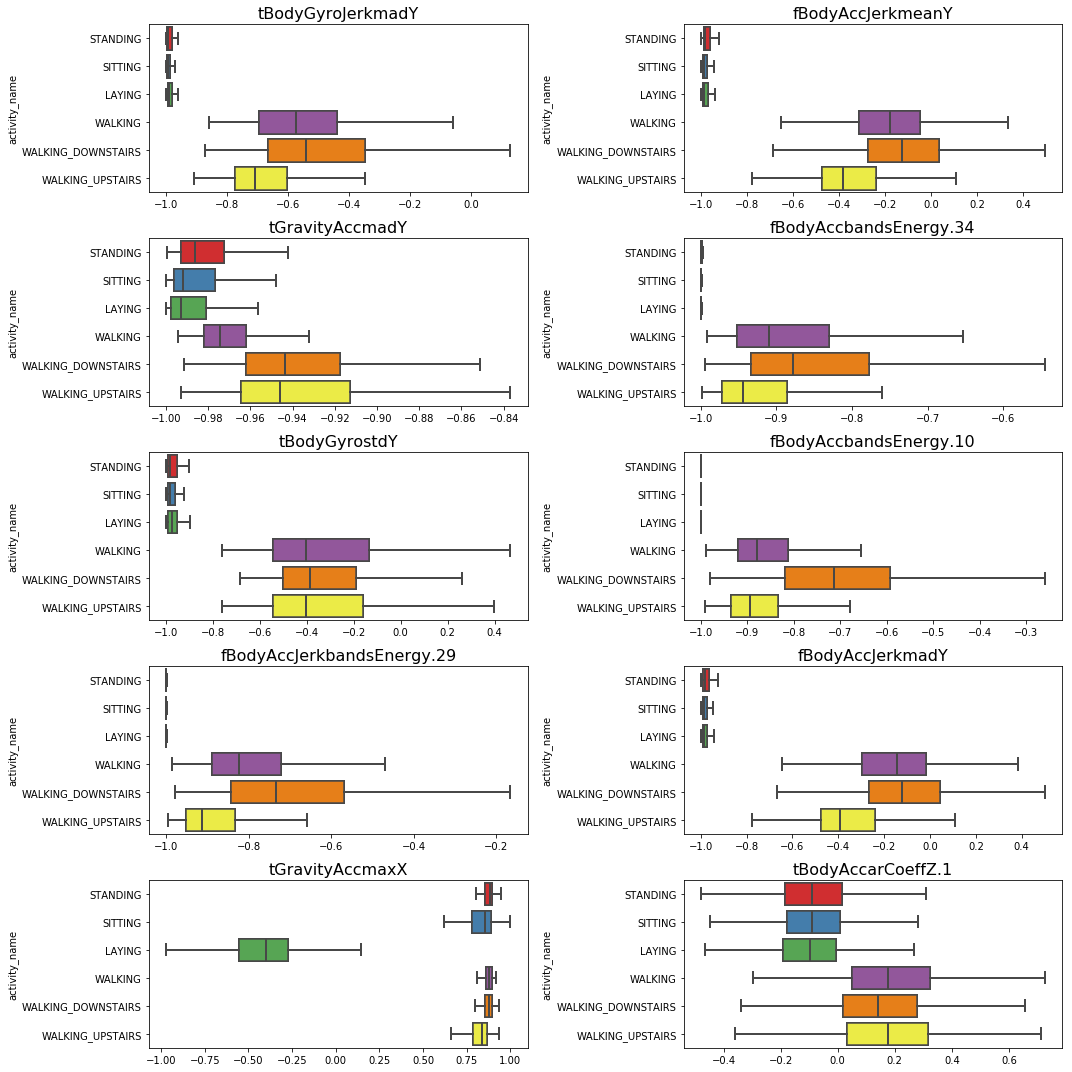

In [81]:
plt.figure(figsize=(15, 15))
p = 1

for feature in np.random.choice(df_train.columns, 10, replace=False):
    plt.subplot(5, 2, p)
    for ix, act in enumerate(df_train.activity_name.unique()):

        sbn.boxplot(y='activity_name',
                    x=feature,
                    data=df_train,
                    showfliers=False,
                    saturation=1)
        plt.title(feature, fontsize=16)
        plt.xlabel('')
    p += 1

plt.tight_layout()

# t-SNE

Let's try to visualize if the 6 types of activities tend to form meaningful clusters after reducing the dimensions of the data. We'll apply t-SNE which is a relatively modern technique for dimensionality reduction. 

In [16]:
plt.figure(figsize=(7,7))
def perform_tsne(X_data, y_data, perplexities, n_iter=1000):

    for index,perplexity in enumerate(perplexities):
        X_reduced = TSNE(verbose=0, perplexity=perplexity).fit_transform(X_data)

        df = pd.DataFrame({'x':X_reduced[:,0], 'y':X_reduced[:,1] ,'label':y_data})

        sbn.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, height=8,\
                   palette="Set1",markers=['^','v','s','o', '1','2'])
        plt.title("perplexity : {} and max_iter : {}".format(perplexity, n_iter), fontsize=16)
    
    plt.show()

<Figure size 504x504 with 0 Axes>

**As you can observe below, t-SNE did a pretty good job of clustering different activities.** Although there's always some overlap in the activites - SITTING and STANDING, which is to be expected, since both are STATIONARY activities and data captured for them by the sensors must be similar.

We'll see later how the ML algorithms perform i.e. whether they are able to successfully distinguish between SITTING and STANDING.

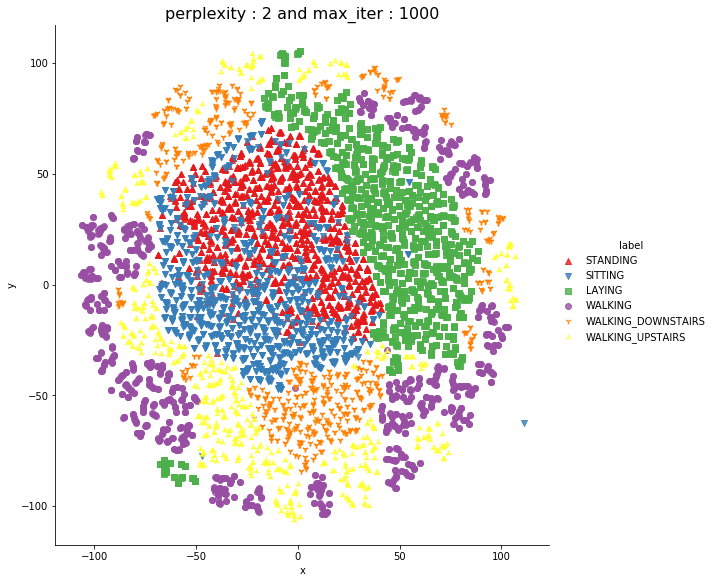

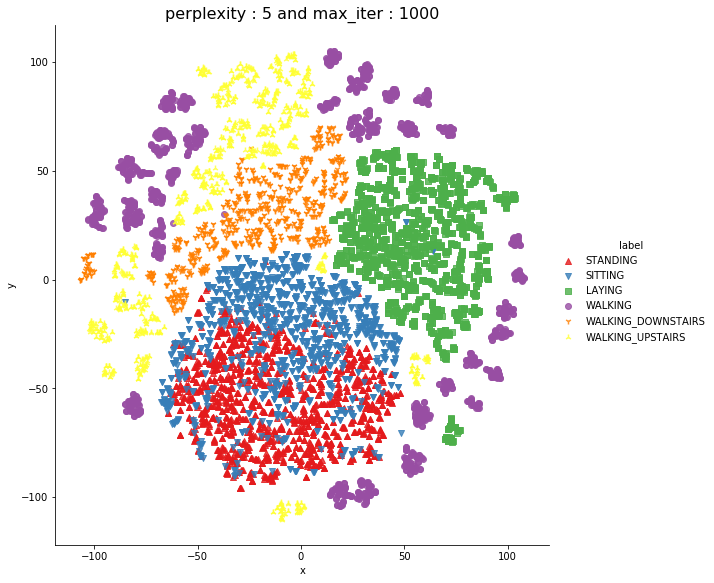

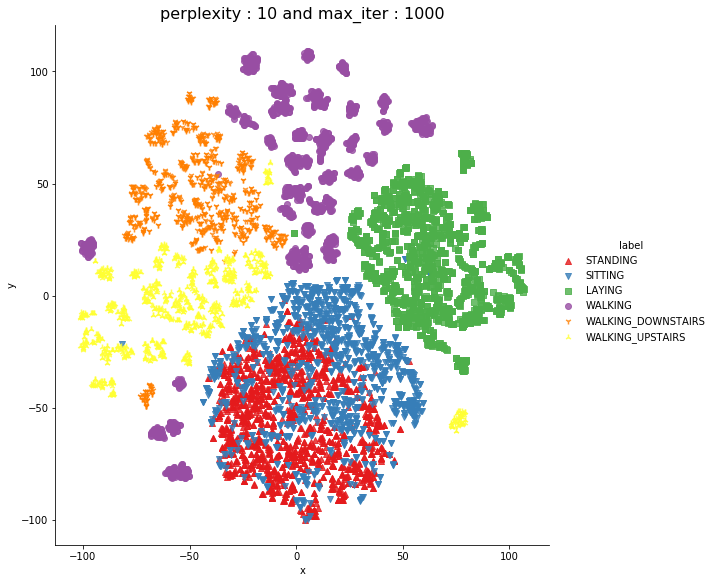

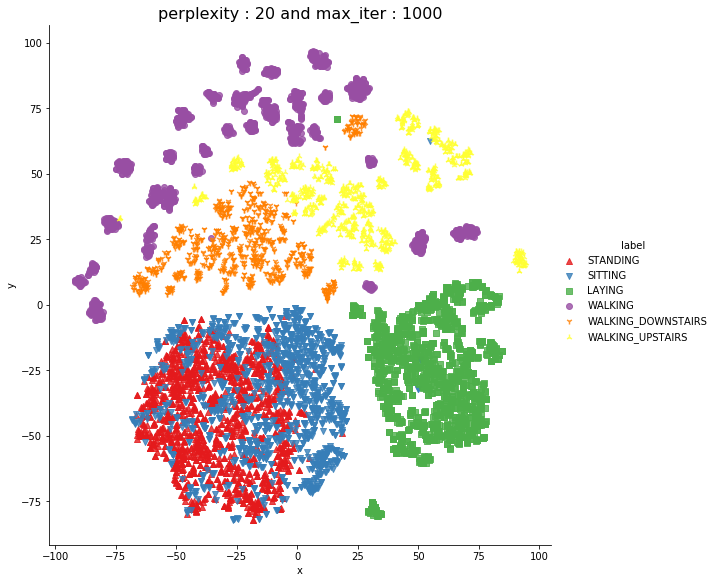

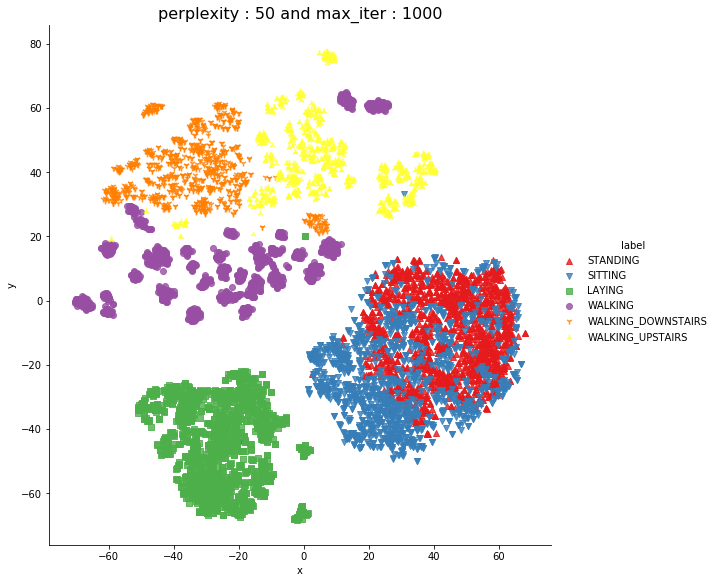

In [21]:
X_pre_tsne = df_train.drop(['subject', 'activity_name', 'activity_type'],
                           axis=1)

y_pre_tsne = df_train['activity_name']

perform_tsne(X_data=X_pre_tsne, y_data=y_pre_tsne, perplexities=[2, 5, 10, 20, 50])

# Machine Learning

EDA is over. Time to build some models!

One last step: let's remove the columns `subject` and `activity_name` from the data, as these are not features from which a model should learn.

In [4]:
df_train.shape, df_test.shape

((7352, 563), (2947, 563))

In [5]:
X_train = df_train.drop(['subject', 'activity_name'], axis=1).values
y_train = df_train['activity_name'].values

X_test = df_test.drop(['subject', 'activity_name'], axis=1).values
y_test = df_test['activity_name'].values

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape 

((7352, 561), (7352,), (2947, 561), (2947,))

**Standardize the data**

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Labels of the target variable**

In [8]:
labels=['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']

In [9]:
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Functions to summarize model performance

Let's create some functions that will summarize a model's performance. This will help me avoid repeating the same code over and over.

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(8,8))
    
    labels=['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

In [11]:
def show_model_performance(grdsrch_model, X_test, y_test, subplot_shape=1):
    
    print('*'*50, 'SUMMARY', '*'*50)
    print('Base parameters:', grdsrch_model.best_params_)
    accuracy = accuracy_score(y_true=y_test, y_pred=grdsrch_model.predict(X_test))
    print('Accuracy (Test data):', np.round(accuracy, 3))
    logloss = grdsrch_model.score(X_test, y_test)
    
    print('Log Loss (Test data):', np.round(logloss,3) * -1.)
    print('*'*43, 'PERFORMANCE REPORT', '*'*43)
    print(classification_report(y_test, grdsrch_model.predict(X_test)))
    cm = confusion_matrix(y_test, grdsrch_model.predict(X_test))
    print('*'*45, 'CONFUSION MATRIX', '*'*45)
    plot_confusion_matrix(cm,
                      classes=labels,
                      normalize=True,
                      title='Normalized confusion matrix',
                      cmap=plt.cm.Blues)
    
    plt.show()
    print('*'*30, 'HYPERPARAMETERS PERFORMANCE (Test data)', '*'*30)
    
    _ = pd.DataFrame(grdsrch_model.cv_results_)[[
    'params', 'mean_test_neg_log_loss', 'mean_test_accuracy']]

    _['mean_test_neg_log_loss'] = _['mean_test_neg_log_loss'] * (-1.)
    
    if subplot_shape == 2:
        plt.figure(figsize=(15,10))
    else:
        plt.figure(figsize=(15,5))
    
    if subplot_shape == 2:
        plt.subplot(2,1,1)
    else:
        plt.subplot(1,2,1)
    ax = _.set_index('params')['mean_test_neg_log_loss'].plot.bar()
    
    plt.title('Log Loss (Test data)', fontsize=16)

    if subplot_shape == 2:
        plt.subplot(2,1,2)
    else:
        plt.subplot(1,2,2)

    ax = _.set_index('params')['mean_test_accuracy'].plot.bar()

    
    plt.title('Accuracy (Test data)', fontsize=16)
    plt.tight_layout()
    plt.show()

**Utility function to print the confusion matrix for neural network models**

In [42]:
def confusion_matrix_(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

# Model 1: Logistic Regression

LR performs really well. We get an accuracy of 94% on test data. Note that since this is a multiclass classification problem where each class has significant distribution in the dataset, accuracy is useful.

Observe from the confusion matrix that the model makes some error between SITTING and STANDING and also between WALKING_UPSTAIRS and WALKING_DOWNSTAIRS.

In [11]:
%%notify

parameters = {'C': [0.01, 1, 10, 100], 'penalty': ['l2', 'l1']}

log_reg = LogisticRegression(solver='saga', multi_class='auto')

grdsrch_LR = GridSearchCV(log_reg,
                            param_grid=parameters,
                            cv=3,
                            verbose=1,
                            n_jobs=-1,
                         scoring=['neg_log_loss', 'accuracy'],
                         refit='neg_log_loss')

grdsrch_LR.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  3.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.01, 1, 10, 100], 'penalty': ['l2', 'l1']},
             pre_dispatch='2*n_jobs', refit='neg_log_loss',
             return_train_score=False, scoring=['neg_log_loss', 'accuracy'],
             verbose=1)

<IPython.core.display.Javascript object>

************************************************** SUMMARY **************************************************
Base parameters: {'C': 1, 'penalty': 'l1'}
Accuracy (Test data): 0.944
Log Loss (Test data): 0.153
******************************************* PERFORMANCE REPORT *******************************************
                    precision    recall  f1-score   support

            LAYING       1.00      0.97      0.99       537
           SITTING       0.94      0.88      0.91       491
          STANDING       0.88      0.95      0.91       532
           WALKING       0.93      0.99      0.96       496
WALKING_DOWNSTAIRS       0.98      0.93      0.96       420
  WALKING_UPSTAIRS       0.95      0.93      0.94       471

          accuracy                           0.94      2947
         macro avg       0.95      0.94      0.94      2947
      weighted avg       0.95      0.94      0.94      2947

********************************************* CONFUSION MATRIX ******************

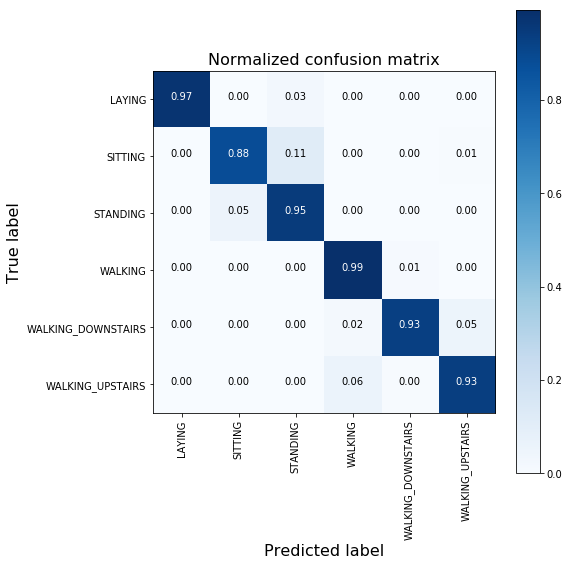

****************************** HYPERPARAMETERS PERFORMANCE (Test data) ******************************


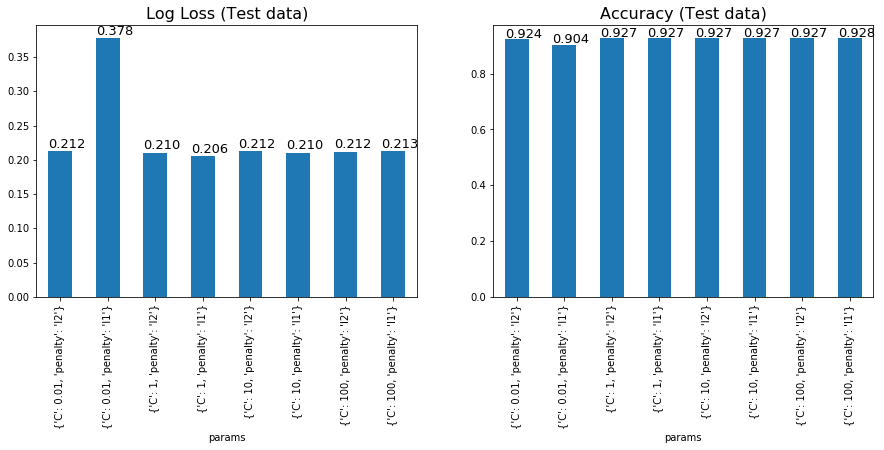

In [37]:
show_model_performance(grdsrch_LR, X_test, y_test)

In [2]:
table = PrettyTable()
table.field_names = ['#', 'Model', '#Features','Accuracy (test data)', 'logloss (test data)']
table.add_row(['1', 'Logistic Regression', '561','0.94', '0.15'])

In [3]:
print(table)

+---+---------------------+-----------+----------------------+---------------------+
| # |        Model        | #Features | Accuracy (test data) | logloss (test data) |
+---+---------------------+-----------+----------------------+---------------------+
| 1 | Logistic Regression |    561    |         0.94         |         0.15        |
+---+---------------------+-----------+----------------------+---------------------+


# Model 2: Linear SVC

This model too perfrms really well with an accuracy of 96%. What small number of errors occur are mostly between SITTING and STANDING.

In [12]:
parameters = {
    'base_estimator__C': [0.125, 0.5, 1, 2, 8, 16],
    'base_estimator__penalty': ['l1', 'l2']
}

svc = LinearSVC(tol=0.00005, dual=False)

c_svc = CalibratedClassifierCV(svc)

grdsrch_svc = GridSearchCV(c_svc,
                           param_grid=parameters,
                           n_jobs=-1,
                           verbose=1,
                           scoring=['neg_log_loss', 'accuracy'],
                           refit='neg_log_loss')

grdsrch_svc.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.0min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0,
                                                                       class_weight=None,
                                                                       dual=False,
                                                                       fit_intercept=True,
                                                                       intercept_scaling=1,
                                                                       loss='squared_hinge',
                                                                       max_iter=1000,
                                                                       multi_class='ovr',
                                                                       penalty='l2',
                                                                       random_state=None,
                                                                 

************************************************** SUMMARY **************************************************
Base parameters: {'base_estimator__penalty': 'l1', 'base_estimator__C': 0.125}
Accuracy (Test data): 0.962
Log Loss (Test data): 0.184
******************************************* PERFORMANCE REPORT *******************************************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.97      0.87      0.92       491
          STANDING       0.89      0.98      0.93       532
           WALKING       0.96      1.00      0.98       496
WALKING_DOWNSTAIRS       1.00      0.97      0.98       420
  WALKING_UPSTAIRS       0.97      0.96      0.96       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947

*********************************************

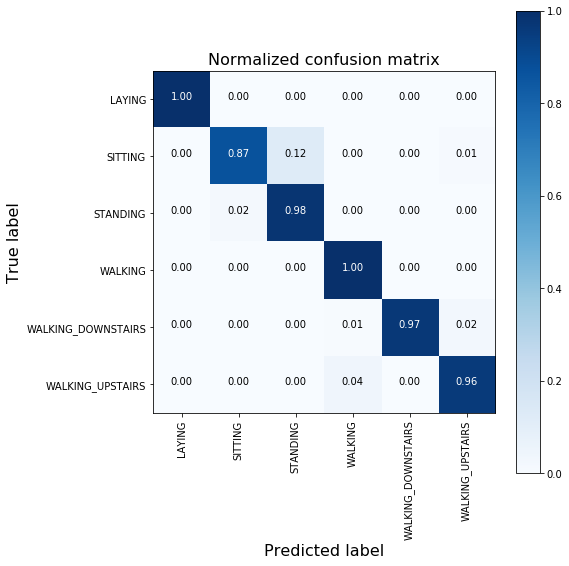

****************************** HYPERPARAMETERS PERFORMANCE (Test data) ******************************


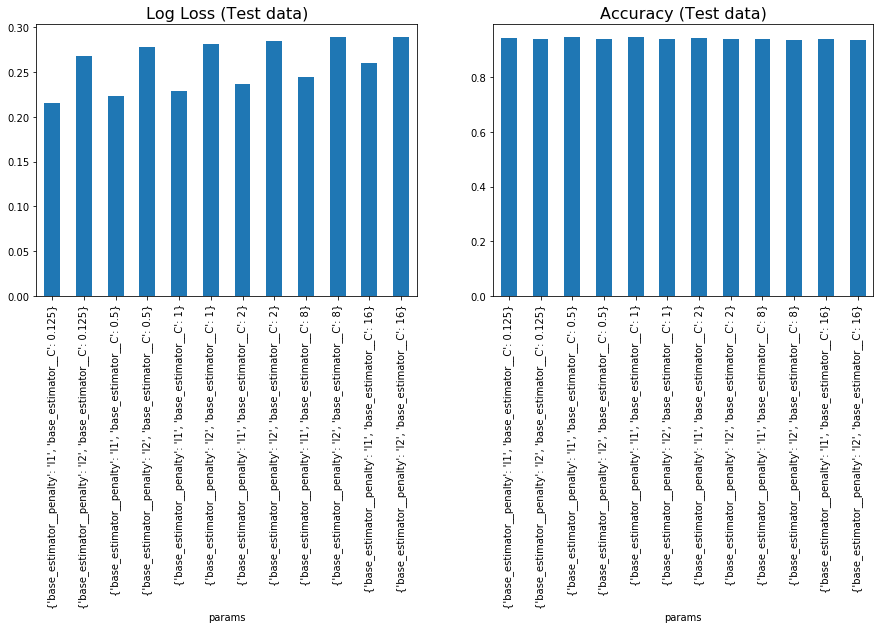

In [13]:
show_model_performance(grdsrch_svc, X_test, y_test)

In [4]:
table.add_row(['2', 'Linear SVC', '561','0.96', '0.18'])

# Model 3: Kernel SVM

This model makes some errors between SITTING and STANDING and also between the walking type of activities. Although it still performs okay with an accuracy of 92%.

In [53]:
%%notify

parameters = {'base_estimator__C':[0.1, 1, 2,8,16],\
              'base_estimator__gamma': [ 0.0078125, 0.125, 2, 5]}

svc_rbf = SVC(kernel='rbf')

c_svc_rbf = CalibratedClassifierCV(svc_rbf)

grdsrch_svc_rbf = GridSearchCV(c_svc_rbf,
                               param_grid=parameters,
                               n_jobs=-1,
                               verbose=1,
                               scoring=['neg_log_loss', 'accuracy'],
                               refit='neg_log_loss')

grdsrch_svc_rbf.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 11.4min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=CalibratedClassifierCV(base_estimator=SVC(C=1.0,
                                                                 cache_size=200,
                                                                 class_weight=None,
                                                                 coef0=0.0,
                                                                 decision_function_shape='ovr',
                                                                 degree=3,
                                                                 gamma='auto_deprecated',
                                                                 kernel='rbf',
                                                                 max_iter=-1,
                                                                 probability=False,
                                                                 random_state=None,
                                            

<IPython.core.display.Javascript object>

************************************************** SUMMARY **************************************************
Base parameters: {'base_estimator__C': 8, 'base_estimator__gamma': 0.0078125}
Accuracy (Test data): 0.927
Log Loss (Test data): 0.388
******************************************* PERFORMANCE REPORT *******************************************
                    precision    recall  f1-score   support

            LAYING       1.00      0.98      0.99       537
           SITTING       0.97      0.90      0.93       491
          STANDING       0.94      0.95      0.95       532
           WALKING       0.95      0.91      0.93       496
WALKING_DOWNSTAIRS       0.77      0.88      0.82       420
  WALKING_UPSTAIRS       0.92      0.93      0.93       471

          accuracy                           0.93      2947
         macro avg       0.93      0.92      0.92      2947
      weighted avg       0.93      0.93      0.93      2947

********************************************* 

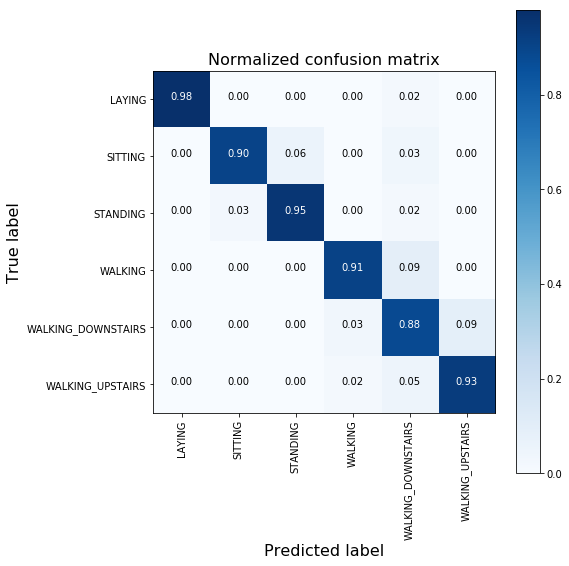

****************************** HYPERPARAMETERS PERFORMANCE (Test data) ******************************


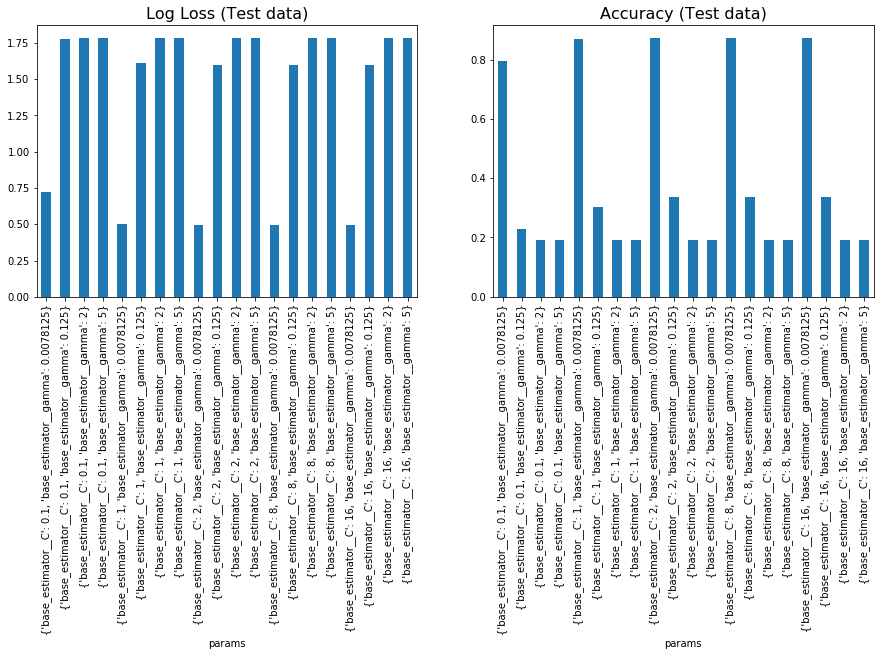

In [54]:
show_model_performance(grdsrch_svc_rbf, X_test, y_test)

In [5]:
table.add_row(['3', 'Kernel SVC', '561','0.93', '0.38'])

# Model 4: Decision Trees

Decision trees give the worst performance among the models trained so far with an accuracy of 72%.
Apart from the expected SITTING and STANDING, this model makes huge errors in the walking activities. None of the WALKING_UPSTAIRS activities are correctly predicted, most of them are classified as WALKING.

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7352, 561), (2947, 561), (7352,), (2947,))

In [20]:
%%notify
parameters = {'max_depth': np.arange(3, 10, 2)}

dt = DecisionTreeClassifier()

grdsrch_dt = GridSearchCV(dt,
                               param_grid=parameters,
                               n_jobs=-1,
                               verbose=1,
                               scoring=['neg_log_loss', 'accuracy'],
                               refit='neg_log_loss')

grdsrch_dt.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    2.4s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.7s finished
/home/givemeaserver/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': array([3, 5, 7, 9])},
             pre_dispatch='2*n_jobs', refit='neg_log_loss',
             

<IPython.core.display.Javascript object>

************************************************** SUMMARY **************************************************
Base parameters: {'max_depth': 3}
Accuracy (Test data): 0.722
Log Loss (Test data): 0.585
******************************************* PERFORMANCE REPORT *******************************************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.79      0.81      0.80       491
          STANDING       0.82      0.80      0.81       532
           WALKING       0.45      0.98      0.61       496
WALKING_DOWNSTAIRS       0.94      0.67      0.78       420
  WALKING_UPSTAIRS       0.00      0.00      0.00       471

          accuracy                           0.72      2947
         macro avg       0.67      0.71      0.67      2947
      weighted avg       0.67      0.72      0.68      2947

********************************************* CONFUSION MATRIX ***************************

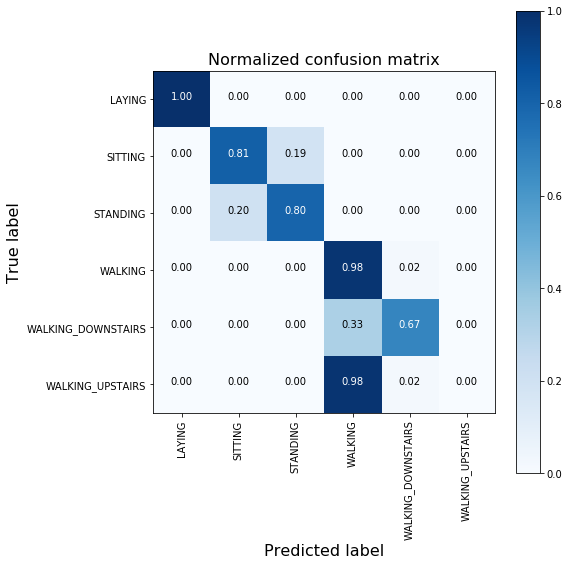

****************************** HYPERPARAMETERS PERFORMANCE (Test data) ******************************


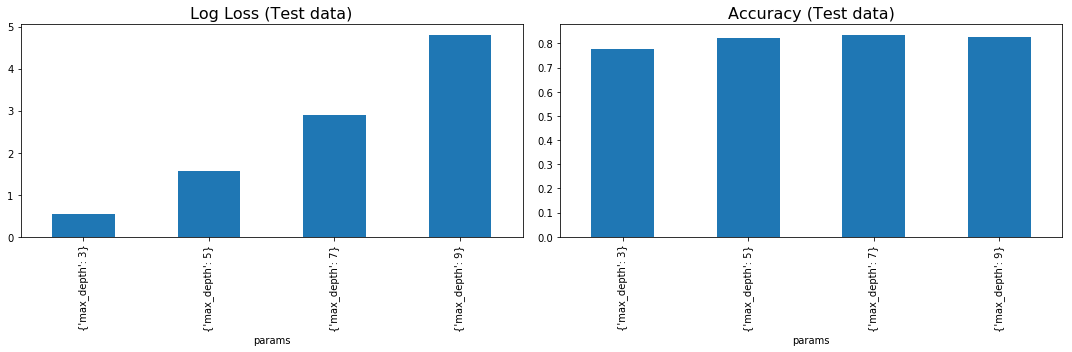

In [21]:
show_model_performance(grdsrch_dt, X_test, y_test)

In [6]:
table.add_row(['4', 'Decision Tree Classifier', '561','0.72', '0.58'])

# Model 5: Random Forest Classifier

RF perform much better than Decision Trees with an accuracy of 92%. Again, this model also gets confused between SITTING and STANDING as well as some walking activities.

In [22]:
%%notify

params = {
    'n_estimators': np.arange(10, 201, 20),
    'max_depth': np.arange(3, 15, 2)
}

rfc = RandomForestClassifier()

grdsrch_rfc = GridSearchCV(rfc,
                               param_grid=params,
                               n_jobs=-1,
                               verbose=1,
                               scoring=['neg_log_loss', 'accuracy'],
                               refit='neg_log_loss')

grdsrch_rfc.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.3min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

<IPython.core.display.Javascript object>

************************************************** SUMMARY **************************************************
Base parameters: {'n_estimators': 150, 'max_depth': 11}
Accuracy (Test data): 0.922
Log Loss (Test data): 0.257
******************************************* PERFORMANCE REPORT *******************************************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.90      0.87      0.88       491
          STANDING       0.88      0.91      0.90       532
           WALKING       0.89      0.97      0.93       496
WALKING_DOWNSTAIRS       0.96      0.85      0.90       420
  WALKING_UPSTAIRS       0.90      0.92      0.91       471

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947

********************************************* CONFUSION MATRIX *****

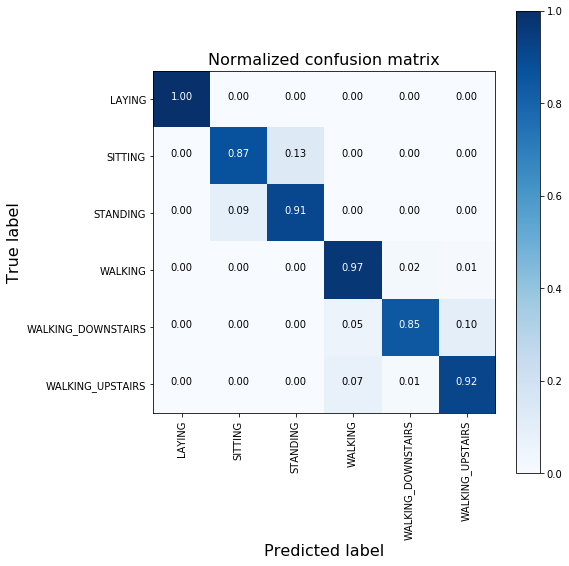

****************************** HYPERPARAMETERS PERFORMANCE (Test data) ******************************


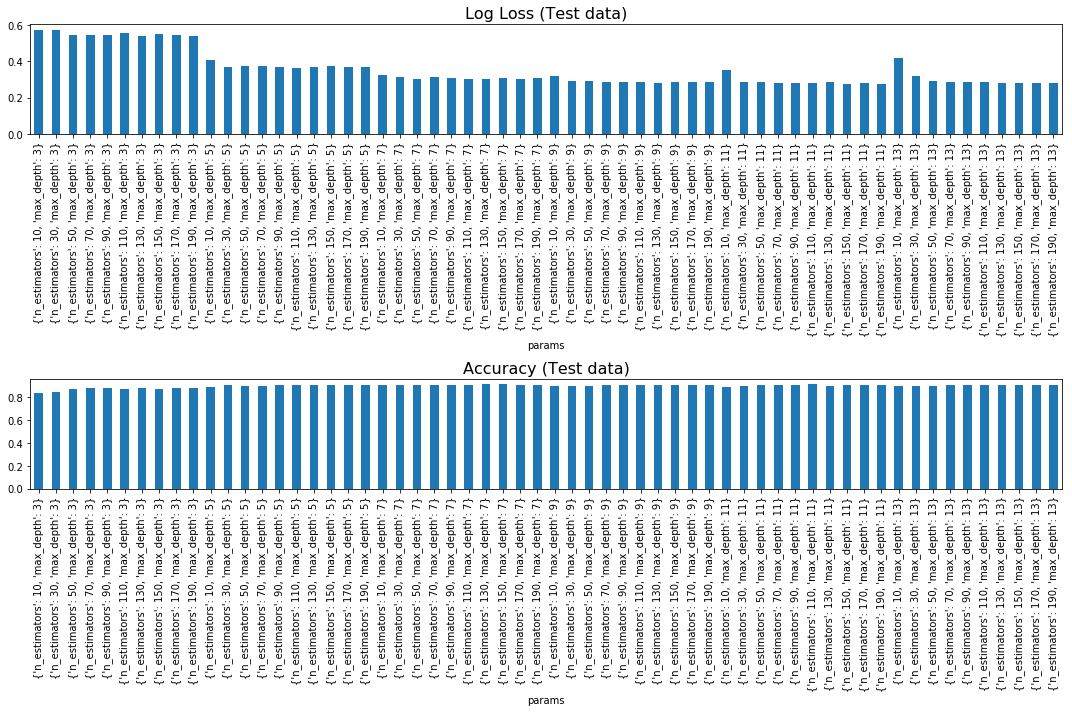

In [23]:
show_model_performance(grdsrch_rfc, X_test, y_test, subplot_shape = 2)

In [7]:
table.add_row(['5', 'Random Forests Classifier', '561','0.92', '0.25'])

# Model 6: Gradient Boosting Classifier

GBDT gives an accuracy of 91%.

In [26]:
%%notify
param_grid = {'max_depth': np.arange(5,8,1), \
             'n_estimators':np.arange(60,200,20)}

gbdt = GradientBoostingClassifier()

grdsrch_gbdt = GridSearchCV(gbdt,
                               param_grid=param_grid,
                               n_jobs=-1,
                               verbose=1,
                               scoring=['neg_log_loss', 'accuracy'],
                               refit='neg_log_loss')

grdsrch_gbdt.fit(X_train, y_train)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed: 37.9min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_it..._change=None,
                                                  preso

<IPython.core.display.Javascript object>

In [28]:
pickle.dump(grdsrch_gbdt, open('grdsrch_gbdt.pkl', 'wb'))

In [24]:
grdsrch_gbdt = pickle.load(open('grdsrch_gbdt.pkl', 'rb'))

************************************************** SUMMARY **************************************************
Base parameters: {'n_estimators': 60, 'max_depth': 5}
Accuracy (Test data): 0.918
Log Loss (Test data): 0.215
******************************************* PERFORMANCE REPORT *******************************************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.91      0.80      0.85       491
          STANDING       0.83      0.93      0.87       532
           WALKING       0.91      0.97      0.94       496
WALKING_DOWNSTAIRS       0.97      0.89      0.92       420
  WALKING_UPSTAIRS       0.91      0.90      0.91       471

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947

********************************************* CONFUSION MATRIX *******

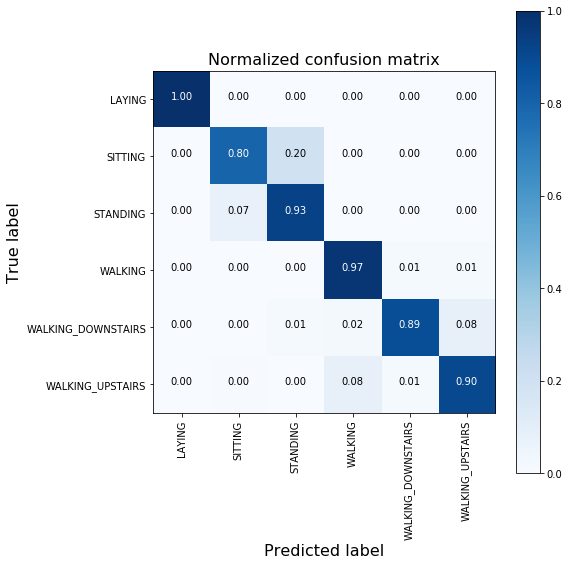

****************************** HYPERPARAMETERS PERFORMANCE (Test data) ******************************


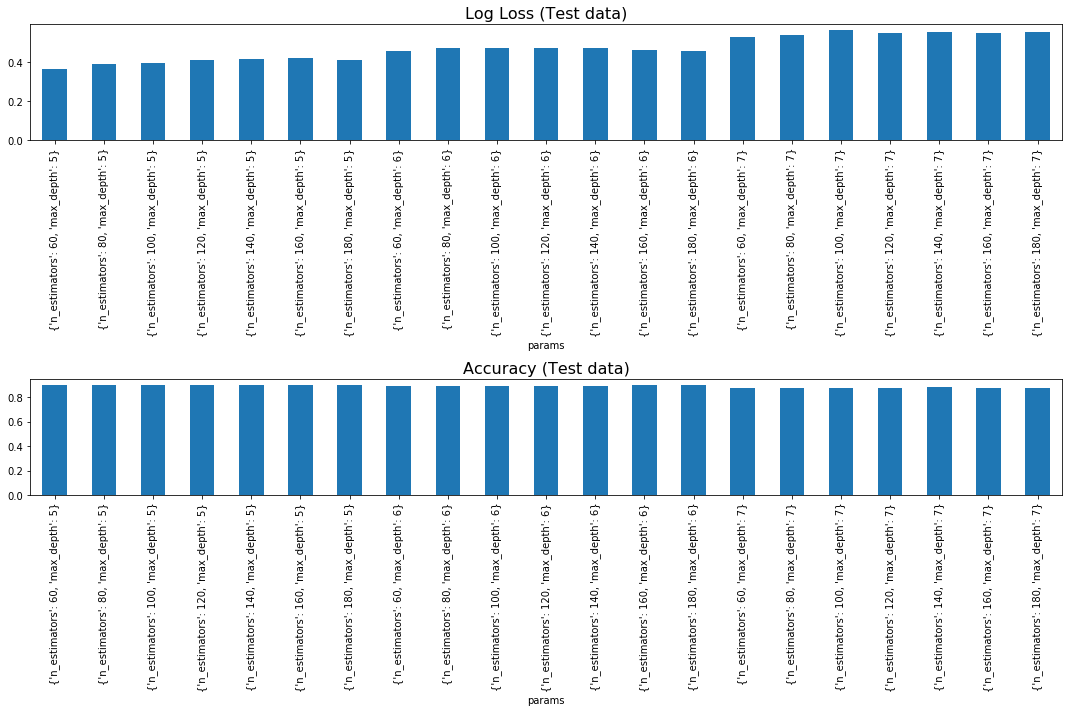

In [25]:
show_model_performance(grdsrch_gbdt, X_test, y_test, subplot_shape = 2)

In [8]:
table.add_row(['6', 'Gradient Boosting Classifier', '561','0.92', '0.21'])

# Model 7: Multi Layered Perceptron

This model is trained on the expert engineered features. The accuracy obtained is 94% which is quite satisfactory.

We need to convert the target label Acitivity into a one hot encoded matrix. First, let's map the activities given as text to a numerical representation. Note that this number is not what will be used as the target variable, because these are categorical values.

In [26]:
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

ACTIVITIES_ = {value: key for key, value in ACTIVITIES.items()}

In [27]:
ACTIVITIES_

{'LAYING': 5,
 'SITTING': 3,
 'STANDING': 4,
 'WALKING': 0,
 'WALKING_DOWNSTAIRS': 2,
 'WALKING_UPSTAIRS': 1}

Add a new column to the dataframes which indicate the activity number against the corresponding activity name

In [28]:
df_train['activity_no'] = df_train['activity_name'].map(ACTIVITIES_)
df_test['activity_no'] = df_test['activity_name'].map(ACTIVITIES_)

In [29]:
X_train = df_train.drop(['subject', 'activity_name', 'activity_no'], axis=1).values
y_train = df_train['activity_no'].values

X_test = df_test.drop(['subject', 'activity_name', 'activity_no'], axis=1).values
y_test = df_test['activity_no'].values

Look at the train data

In [30]:
X_train

array([[ 0.28858451, -0.02029417, -0.13290514, ..., -0.84124676,
         0.17994061, -0.05862692],
       [ 0.27841883, -0.01641057, -0.12352019, ..., -0.8447876 ,
         0.18028889, -0.05431672],
       [ 0.27965306, -0.01946716, -0.11346169, ..., -0.84893347,
         0.18063731, -0.04911782],
       ...,
       [ 0.27338737, -0.01701062, -0.04502183, ..., -0.77913261,
         0.24914484,  0.04081119],
       [ 0.28965416, -0.01884304, -0.15828059, ..., -0.78518142,
         0.24643223,  0.02533948],
       [ 0.35150347, -0.01242312, -0.20386717, ..., -0.78326693,
         0.24680852,  0.03669484]])

the target variable indicates the number of the activity. We are going to One-Hot-Encode this array.

In [31]:
y_train

array([4, 4, 4, ..., 1, 1, 1])

**Standardize the data**

In [32]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Convert activity_no into a one-hot-encoding representation**

In [33]:
from keras.utils import np_utils

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

Here's what the target matrix looks like after OH encoding.

In [34]:
y_train

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

**Build the model**

In [37]:
model_mlp = Sequential()
model_mlp.add(
    Dense(128,
          activation='relu',
          input_shape=(561, )))

#kernel_regularizer=l1(0.001),)

model_mlp.add(Dropout(.3))
model_mlp.add(Dense(64, activation='relu'))
model_mlp.add(Dropout(.3))
model_mlp.add(Dense(32, activation='relu'))
model_mlp.add(Dropout(.5))
model_mlp.add(Dense(6, activation='softmax'))
model_mlp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               71936     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                

**Compile the model**

In [38]:
model_mlp.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

**Train the model**

In [40]:
model_mlp.fit(X_train, y_train, batch_size=32, epochs=35)


Epoch 1/35
7352/7352 [==============================] - 1s 96us/step - loss: 0.9679 - accuracy: 0.6536
Epoch 2/35
7352/7352 [==============================] - 0s 63us/step - loss: 0.4055 - accuracy: 0.8603
Epoch 3/35
7352/7352 [==============================] - 0s 63us/step - loss: 0.2703 - accuracy: 0.9113
Epoch 4/35
7352/7352 [==============================] - 0s 63us/step - loss: 0.2088 - accuracy: 0.9305
Epoch 5/35
7352/7352 [==============================] - 0s 62us/step - loss: 0.1731 - accuracy: 0.9415
Epoch 6/35
7352/7352 [==============================] - 0s 63us/step - loss: 0.1731 - accuracy: 0.9518
Epoch 7/35
7352/7352 [==============================] - 0s 63us/step - loss: 0.1330 - accuracy: 0.9553
Epoch 8/35
7352/7352 [==============================] - 0s 62us/step - loss: 0.1402 - accuracy: 0.9614
Epoch 9/35
7352/7352 [==============================] - 0s 62us/step - loss: 0.1417 - accuracy: 0.9610
Epoch 10/35
7352/7352 [==============================] - 0s 62us/step - 

In [41]:
model_mlp.evaluate(X_test, y_test)

2947/2947 [==============================] - 0s 34us/step


[0.7237876816799055, 0.9494401216506958]

This model too makes the same errors as the models before. Some SITTING values are predicted as STANDING and vise versa. Same goes for Walking activities.

In [44]:
confusion_matrix_(y_test, model_mlp.predict(X_test))

Pred,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
True,,,,,,
LAYING,524,0,13,0,0,0
SITTING,2,436,52,0,0,1
STANDING,0,18,513,1,0,0
WALKING,0,0,0,487,5,4
WALKING_DOWNSTAIRS,0,0,0,10,391,19
WALKING_UPSTAIRS,0,0,0,19,5,447


In [9]:
table.add_row([
    '7',
    'Multi Layered Perceptron\n[I/P-D(128)-D/O-D(64)-D/O-D(32)-D/O-Out(6)]',
    '561', '0.94', '0.72'
])

# Model 8: RNN with one LSTM

In this section, we'll build a slightly advanced neural network called a Recurrent Neural Network using LSTM. Before we build the model, we need to change the shape of the data to work with an LSTM network. Let's understand how that will be done. Consider the following `list of numpy arrays`. This is a list containing 3 arrays.

In [45]:
l = [
    np.array([[2, 1, 34, 11], [43, 11, 53, 22]]),
    np.array([[5, 3, 46, 21], [234, 232, -23, -122]]),
    np.array([[3, 11, -33, -2], [325, 64, -2, -2222]])
]

Each array in the list has a shape of `2x4`. Let `2` indicate the number of samples and `4` the number of timesteps

In [46]:
l[0].shape, l[1].shape, l[2].shape

((2, 4), (2, 4), (2, 4))

Notice what happens when we transpose this list of arrays

In [47]:
print(np.transpose([
    np.array([[2, 1, 34, 11], [43, 11, 53, 22]]),
    np.array([[5, 3, 46, 21], [234, 232, -23, -122]]),
    np.array([[3, 11, -33, -2], [325, 64, -2, -2222]])
],
             axes=(1, 2, 0)))

[[[    2     5     3]
  [    1     3    11]
  [   34    46   -33]
  [   11    21    -2]]

 [[   43   234   325]
  [   11   232    64]
  [   53   -23    -2]
  [   22  -122 -2222]]]


The transformed array is in the format of 
        
        Number of samples(batch size) x Number of Timesteps x Number of features (sequence length)
keep this in mind as this will be referred to later.

In [48]:
np.transpose([
    np.array([[2, 1, 34, 11], [43, 11, 53, 22]]),
    np.array([[5, 3, 46, 21], [234, 232, -23, -122]]),
    np.array([[3, 11, -33, -2], [325, 64, -2, -2222]])
],
             axes=(1, 2, 0)).shape

(2, 4, 3)

**Define the name of the raw signal files**

In [50]:
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

**Utility function to read the data from csv file**

Here, we apply the `transpose` operation we just saw above. The for loop below loads each raw signal file and stores them as a list of 9 numpy arrays. One array for each signal file defined above.  

In [51]:
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = "HAR/UCI_HAR_Dataset/{}/Inertial Signals/{}_{}.txt".format(subset, signal,subset)
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

**One hot encoded target label**

In [52]:
def load_y(subset):

    filename = 'HAR/UCI_HAR_Dataset/{}/y_{}.txt'.format(subset, subset)
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

**Main driver function that utilizes the secondary functions above to return train and test datasets** 

In [53]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

**Load data**

In [54]:
X_train, X_test, Y_train, Y_test = load_data()

In [55]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((7352, 128, 9), (7352, 6), (2947, 128, 9), (2947, 6))

In [56]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [57]:
#load_signals('train')load_signals('train')
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print('The number of Timesteps:', timesteps)
print('Input Dimensions:',input_dim)
print('Size of the training data', len(X_train))

The number of Timesteps: 128
Input Dimensions: 9
Size of the training data 7352


**Build the model**

In [59]:
# Initializing parameters
epochs = 30
batch_size = 32
n_hidden = 32

In [60]:
model_lstm_1 = Sequential()
model_lstm_1.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
model_lstm_1.add(Dropout(0.5))
model_lstm_1.add(Dense(n_classes, activation='sigmoid'))
model_lstm_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [61]:
model_lstm_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [62]:
model_lstm_1.fit(X_train, Y_train, batch_size=32, epochs=35)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/35
7352/7352 [==============================] - 11s 2ms/step - loss: 1.4372 - accuracy: 0.4142
Epoch 2/35
7352/7352 [==============================] - 10s 1ms/step - loss: 1.2416 - accuracy: 0.4737
Epoch 3/35
7352/7352 [==============================] - 11s 1ms/step - loss: 1.0892 - accuracy: 0.5310
Epoch 4/35
7352/7352 [==============================] - 12s 2ms/step - loss: 1.1993 - accuracy: 0.4888
Epoch 5/35
7352/7352 [==============================] - 11s 1ms/step - loss: 0.9843 - accuracy: 0.5669
Epoch 6/35
7352/7352 [==============================] - 10s 1ms/step - loss: 0.9022 - accuracy: 0.5668
Epoch 7/35
7352/7352 [==============================] - 11s 1ms/step - loss: 0.9976 - accuracy: 0.5676
Epoch 8/35
7352/7352 [==============================] - 11s 1ms/step - loss: 0.9501 - accuracy: 0.5756
Epoch 9/35
7352/7352 [==============================] - 10s 1ms/step - loss: 0.927

This model makes quite a few errors while predicting the SITTING class. A large chunk of SITTING records were predicted as STANDING and WALKING_UPSTAIRS.

In [64]:
confusion_matrix_(Y_test, model_lstm_1.predict(X_test))

Pred,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
True,,,,,,
LAYING,519,0,0,0,0,18
SITTING,0,363,102,0,0,26
STANDING,0,97,392,19,0,24
WALKING,0,0,0,450,22,24
WALKING_DOWNSTAIRS,0,0,0,31,378,11
WALKING_UPSTAIRS,0,1,1,36,25,408


In [65]:
model_lstm_1.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 382us/step


[0.5316041498844745, 0.8517135977745056]

In [11]:
table.add_row([
    '8',
    'Recurrent Neural Network\n[I/P-LSTM(32)-D/O(32)-Out(6)]',
    '9', '0.85', '0.53'
])

# Model 9: Two LSTM layers (with regularization) + 1  Dense layer with Dropouts

This is a more complex model that the previous one. This also employs regularization in the LSTM layers to avoid overfitting.

In [66]:
model_lstm_2 = Sequential()

model_lstm_2.add(LSTM(64, input_shape=(128, 9), return_sequences=True, kernel_regularizer=l2(0.01)))
model_lstm_2.add(LSTM(32, kernel_regularizer=l2(0.01)))

model_lstm_2.add(Dense(32))
model_lstm_2.add(Dropout(0.5))

model_lstm_2.add(Dense(6, activation='sigmoid'))
model_lstm_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 198       
Total params: 32,614
Trainable params: 32,614
Non-trainable params: 0
_________________________________________________________________


In [67]:
model_lstm_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [68]:
model_lstm_2.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/30
7352/7352 [==============================] - 24s 3ms/step - loss: 1.5914 - accuracy: 0.4246
Epoch 2/30
7352/7352 [==============================] - 23s 3ms/step - loss: 1.0835 - accuracy: 0.5447
Epoch 3/30
7352/7352 [==============================] - 23s 3ms/step - loss: 0.8452 - accuracy: 0.6255
Epoch 4/30
7352/7352 [==============================] - 23s 3ms/step - loss: 0.8743 - accuracy: 0.6089
Epoch 5/30
7352/7352 [==============================] - 23s 3ms/step - loss: 1.2864 - accuracy: 0.4629
Epoch 6/30
7352/7352 [==============================] - 23s 3ms/step - loss: 1.0739 - accuracy: 0.5499
Epoch 7/30
7352/7352 [==============================] - 23s 3ms/step - loss: 0.8811 - accuracy: 0.6094
Epoch 8/30
7352/7352 [==============================] - 24s 3ms/step - loss: 1.0009 - accuracy: 0.5680
Epoch 9/30
7352/7352 [==============================] - 24s 3ms/step - loss: 0.7917 - accuracy: 0.6333
Epoch 10/30
7352/7352 [==============================] - 24s 3ms/step - l

This model surprisingly performs the worst of all. Apart from LAYING, for some unknown reason all other activities were predicted to be WALKING_UPSTAIRS.

In [70]:
confusion_matrix_(Y_test, model_lstm_2.predict(X_test))

Pred,LAYING,STANDING,WALKING,WALKING_UPSTAIRS
True,,,,
LAYING,471,1,2,63
SITTING,0,0,0,491
STANDING,0,0,0,532
WALKING,0,0,1,495
WALKING_DOWNSTAIRS,0,0,1,419
WALKING_UPSTAIRS,0,0,0,471


In [71]:
model_lstm_2.evaluate(X_test, Y_test)

2947/2947 [==============================] - 3s 860us/step


[1.6417573250306838, 0.3199864327907562]

In [13]:
table.add_row([
    '9',
    'Recurrent Neural Network\n[I/P-LSTM(64)-LSTM(32)-D(32)-D/O-Out(6)]',
    '9', '0.32', '1.64'
])

# Concluding Remarks

* This was a 6 class classification problem. We used the data given in two different formats.
    - Expert engineered features
    - Raw signal files from the accelerometer and the Gyroscope
* Using the expert engineered features, traditional ML models were trained, while the raw signal data was used to train Neural Nets (MLP & LSTM recurrent neural nets)

* Most models erred to some extent between classes SITTING and STANDING. But with better quality Gyroscopes and Accelerometers even this problem might be mitigated. 

* The best performance was obtained using Linear SVC. We got a satisfactory accuracy of **96%** and logloss of **0.18** on test data using this model. The complete summary of the models trained can be found below.

In [14]:
print(table)

+---+---------------------------------------------+-----------+----------------------+---------------------+
| # |                    Model                    | #Features | Accuracy (test data) | logloss (test data) |
+---+---------------------------------------------+-----------+----------------------+---------------------+
| 1 |             Logistic Regression             |    561    |         0.94         |         0.15        |
| 2 |                  Linear SVC                 |    561    |         0.96         |         0.18        |
| 3 |                  Kernel SVC                 |    561    |         0.93         |         0.38        |
| 4 |           Decision Tree Classifier          |    561    |         0.72         |         0.58        |
| 5 |          Random Forests Classifier          |    561    |         0.92         |         0.25        |
| 6 |         Gradient Boosting Classifier        |    561    |         0.92         |         0.21        |
| 7 |           Mul